In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Time delay surfaces

Now we use the same functions used in Notebook 6 to study the time delay surfaces of our lens. Below, I copied the code for the general lens ```genlen```. We will then declare the class deflector as a child of this class, in order it can inherit all methods of the parent class.

In [2]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('font', **font)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import map_coordinates
import pylab
import astropy.io.fits as pyfits
from scipy.ndimage import map_coordinates
import numpy.fft as fftengine


# the parent class
class gen_lens(object):
    def __init__(self):
        self.pot_exists=False
    
    # geometrical time delay: proportional to (theta-beta)**2
    def t_geom_surf(self, beta=None):
        # this is a method to create a mesh of coordinates (x,y)
        # note that x,y vary between 0 and npix*pixel
        x = np.arange(0, self.npix, 1, float)*self.pixel
        y = x[:,np.newaxis]
        # if there is a source at beta, compute its coordinates (x0,y0)
        # it no source position is provided, set the position at the center of the grid
        if beta is None:
            x0 = y0 = self.npix / 2*self.pixel
        else:
            x0 = beta[0]+self.npix/2*self.pixel
            y0 = beta[1]+self.npix/2*self.pixel
        # now we can compute the geometrical time delay surface:
        return 0.5*((x-x0)*(x-x0)+(y-y0)*(y-y0))
    
    # gravitational time delay: this is just the lensing potential (times -1)
    def t_grav_surf(self):
        return -self.pot
    
    # total time delay: computed by summing the geometrical and the gravitational time delays
    def t_delay_surf(self,beta=None):
        t_grav=self.t_grav_surf()
        t_geom=self.t_geom_surf(beta)
        td=(t_grav+t_geom)
        return(t_grav+t_geom)
    
    # convergence: computed from the laplacian of the lensing potential 
    def convergence(self):
        if (self.pot_exists):
            kappa=0.5*(self.a11+self.a22)
        else:
            print ("The lens potential is not initialized yet")
            
        return(kappa)
    
    #shear: computed from other combinantions of the lensing potential
    def shear(self):
        if (self.pot_exists):
            g1=0.5*(self.a11-self.a22)
            g2=self.a12
        else:
            print ("The lens potential is not initialized yet")
        return(g1,g2)
    
    # determinant of the Jacobian matrix
    def detA(self):
        if (self.pot_exists):
            deta=(1.0-self.a11)*(1.0-self.a22)-self.a12*self.a21
        else:
            print ("The lens potential is not initialized yet")
        return(deta)
    
    # critical lines overlaid to the map of detA, returns a set of contour objects
    def crit_lines(self,ax=None,show=True):
        if (ax==None): 
            print ("specify the axes to display the critical lines")
        else:
            deta=self.detA()
            #ax.imshow(deta,origin='lower')
            cs=ax.contour(deta,levels=[0.0],colors='white',alpha=0.0)
            if show==False:
                ax.clear()
        return(cs)
    
    # plot of the critical lines
    def clines(self,ax=None,color='red',alpha=1.0,lt='-',fontsize=15):
        cs=self.crit_lines(ax=ax,show=False)
        contour=cs.collections[0]
        p=contour.get_paths()
        sizevs=np.empty(len(p),dtype=int)
        
        no=self.pixel
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                #the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
        
                # plot the results!
                ax.plot((np.array(x1)-self.npix/2.)*no,
                        (np.array(x2)-self.npix/2.)*no,lt,color=color,alpha=alpha)
        ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
        ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
    
    # plot of the caustics
    def caustics(self,ax=None,alpha=1.0,color='red',lt='-',fontsize=15):
        cs=self.crit_lines(ax=ax,show=True)
        contour=cs.collections[0]
        p=contour.get_paths() # p contains the paths of each individual 
                              # critical line
        sizevs=np.empty(len(p),dtype=int)
        
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                # the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
                # these are the points we want to map back on the source plane. 
                # To do that we need to evaluate the deflection angle at their positions
                # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
                a_1=map_coordinates(self.a1, [[x2],[x1]],order=1)
                a_2=map_coordinates(self.a2, [[x2],[x1]],order=1)
        
                # now we can make the mapping using the lens equation:
                no=self.pixel
                y1=(x1-a_1[0]-self.npix/2.)*no
                y2=(x2-a_2[0]-self.npix/2.)*no
        
                # plot the results!
                #ax.plot((np.array(x1)-npix/2.)*no*f,(np.array(x2)-npix/2.)*no*f,'-')
                ax.plot(y1,y2,lt,color=color,alpha=alpha)
            ax.set_xlabel(r'$\beta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\beta_2$',fontsize=fontsize)
                
    # display the time delay surface
    def show_surface(self,surf0,ax=None,minx=-25,miny=-25,vmax=2,rstride=1,
                     cstride=1,cmap=plt.get_cmap('Paired'),
                     linewidth=0, antialiased=False,alpha=0.2,fontsize=20,offz=0.0):
        
        surf=surf0+offz
        if ax==None:
            print ("specify the axes with 3d projection to display the surface")
        else:
            xa=np.arange(-self.npix/2, self.npix/2, 1)
            ya=np.arange(-self.npix/2, self.npix/2, 1)
        # I will show the contours levels projected in the x-y plane
            levels=np.linspace(np.amin(surf),np.amax(surf),40)

            minx=minx
            maxx=-minx

            miny=miny
            maxy=-miny

            pixel_size=self.size/(self.npix-1)
            X, Y = np.meshgrid(xa*pixel_size, ya*pixel_size)
            ax.plot_surface(X,Y,surf,vmax=vmax,rstride=rstride, cstride=cstride, cmap=cmap,
                       linewidth=linewidth, antialiased=antialiased,alpha=alpha)

            cset = ax.contour(X, Y, surf, zdir='z', 
                               offset=np.amin(surf)-20.0, cmap=cmap,levels=levels)
            deta=self.detA()
            cset = ax.contour(X, Y, deta, zdir='z', 
                               offset=np.amin(surf)-20.0, colors='black',levels=[0])            
            cset = ax.contour(X, Y, surf, zdir='x', offset=minx, cmap=cmap,levels=[0])
            cset = ax.contour(X, Y, surf, zdir='y', offset=maxy, cmap=cmap,levels=[0])
            ax.set_xlim3d(minx, maxx)
            ax.set_ylim3d(miny, maxy)
            ax.set_zlim3d(np.amin(surf)-20.0, 10)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('equal')            

    # display the time delay contours
    def show_contours(self,surf0,ax=None,minx=-25,miny=-25,cmap=plt.get_cmap('Paired'),
                     linewidth=1,fontsize=20,nlevels=40,levmax=100,offz=0.0):
        if ax==None:
            print ("specify the axes to display the contours")
        else:
            minx=minx
            maxx=-minx
            miny=miny
            maxy=-miny
            surf=surf0-np.min(surf0)
            levels=np.linspace(np.min(surf),levmax,nlevels)
            ax.contour(surf, cmap=cmap,levels=levels,
                       linewidth=linewidth,
                       extent=[-self.size/2,self.size/2,-self.size/2,self.size/2])
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('equal')  
            
            
# child class deflector  
class deflector(gen_lens):

    
    # initialize the deflector using a surface density (covergence) map
    # the boolean variable pad indicates whether zero-padding is used or not
    
    def __init__(self,filekappa,pad=False,npix=200,size=100):
        kappa,header=pyfits.getdata(filekappa,header=True)
        self.pixel_scale=header['CDELT2']*3600.0
        self.kappa=kappa
        self.nx=kappa.shape[0]
        self.ny=kappa.shape[1]
        self.pad=pad
        self.npix=npix
        self.size=size
        self.pixel=float(self.size)/float(self.npix-1)
        if (pad):
            self.kpad()
        self.potential()
        
    # performs zero-padding
    def kpad(self):
        # add zeros around the original array
        def padwithzeros(vector, pad_width, iaxis, kwargs):
            vector[:pad_width[0]] = 0
            vector[-pad_width[1]:] = 0
            return vector
        # use the pad method from numpy.lib to add zeros (padwithzeros) in a
        # frame with thickness self.kappa.shape[0]
        self.kappa=np.lib.pad(self.kappa, self.kappa.shape[0], 
                              padwithzeros)
        
    # calculate the potential by solving the poisson equation
    def potential_from_kappa(self):
        # define an array of wavenumbers (two components k1,k2)
        k = np.array(np.meshgrid(fftengine.fftfreq(self.kappa.shape[0])\
                                 ,fftengine.fftfreq(self.kappa.shape[1])))
        pix=1 # pixel scale (now using pixel units)
        #Compute Laplace operator in Fourier space = -4*pi*k^2
        kk = k[0]**2 + k[1]**2
        kk[0,0] = 1.0
        #FFT of the convergence
        kappa_ft = fftengine.fftn(self.kappa)
        #compute the FT of the potential
        kappa_ft *= - pix**2 / (kk * (2.0*np.pi**2))
        kappa_ft[0,0] = 0.0
        potential=fftengine.ifftn(kappa_ft) #units should be rad**2
        if self.pad:
            pot=self.mapCrop(potential.real)
        return pot
    
    # returns the map of the gravitational time delay
    def potential(self):
        no=self.pixel
        x_ = np.linspace(0,self.npix-1,self.npix)
        y_ = np.linspace(0,self.npix-1,self.npix)
        x,y=np.meshgrid(x_,y_)
        potential=self.potential_from_kappa()
        x0 = y0 = potential.shape[0] / 2*self.pixel_scale-self.size/2.0
        x=(x0+x*no)/self.pixel_scale
        y=(y0+y*no)/self.pixel_scale
        self.pot_exists=True
        pot=map_coordinates(potential,[[y],[x]],order=1).reshape(int(self.npix),int(self.npix))
        self.pot=pot*self.pixel_scale**2/no/no
        self.a2,self.a1=np.gradient(self.pot)
        self.a12,self.a11=np.gradient(self.a1)
        self.a22,self.a21=np.gradient(self.a2)
        self.pot=pot*self.pixel_scale**2
        

    # crop the maps to remove zero-padded areas and get back to the original 
    # region.
    def mapCrop(self,mappa):
        xmin=int(self.kappa.shape[0]/2-self.nx/2)
        ymin=int(self.kappa.shape[1]/2-self.ny/2)
        xmax=int(xmin+self.nx)
        ymax=int(ymin+self.ny)
        mappa=mappa[xmin:xmax,ymin:ymax]
        return(mappa)

Now we use the code above to display some time delay surfaces for the different source positions.

<IPython.core.display.Javascript object>


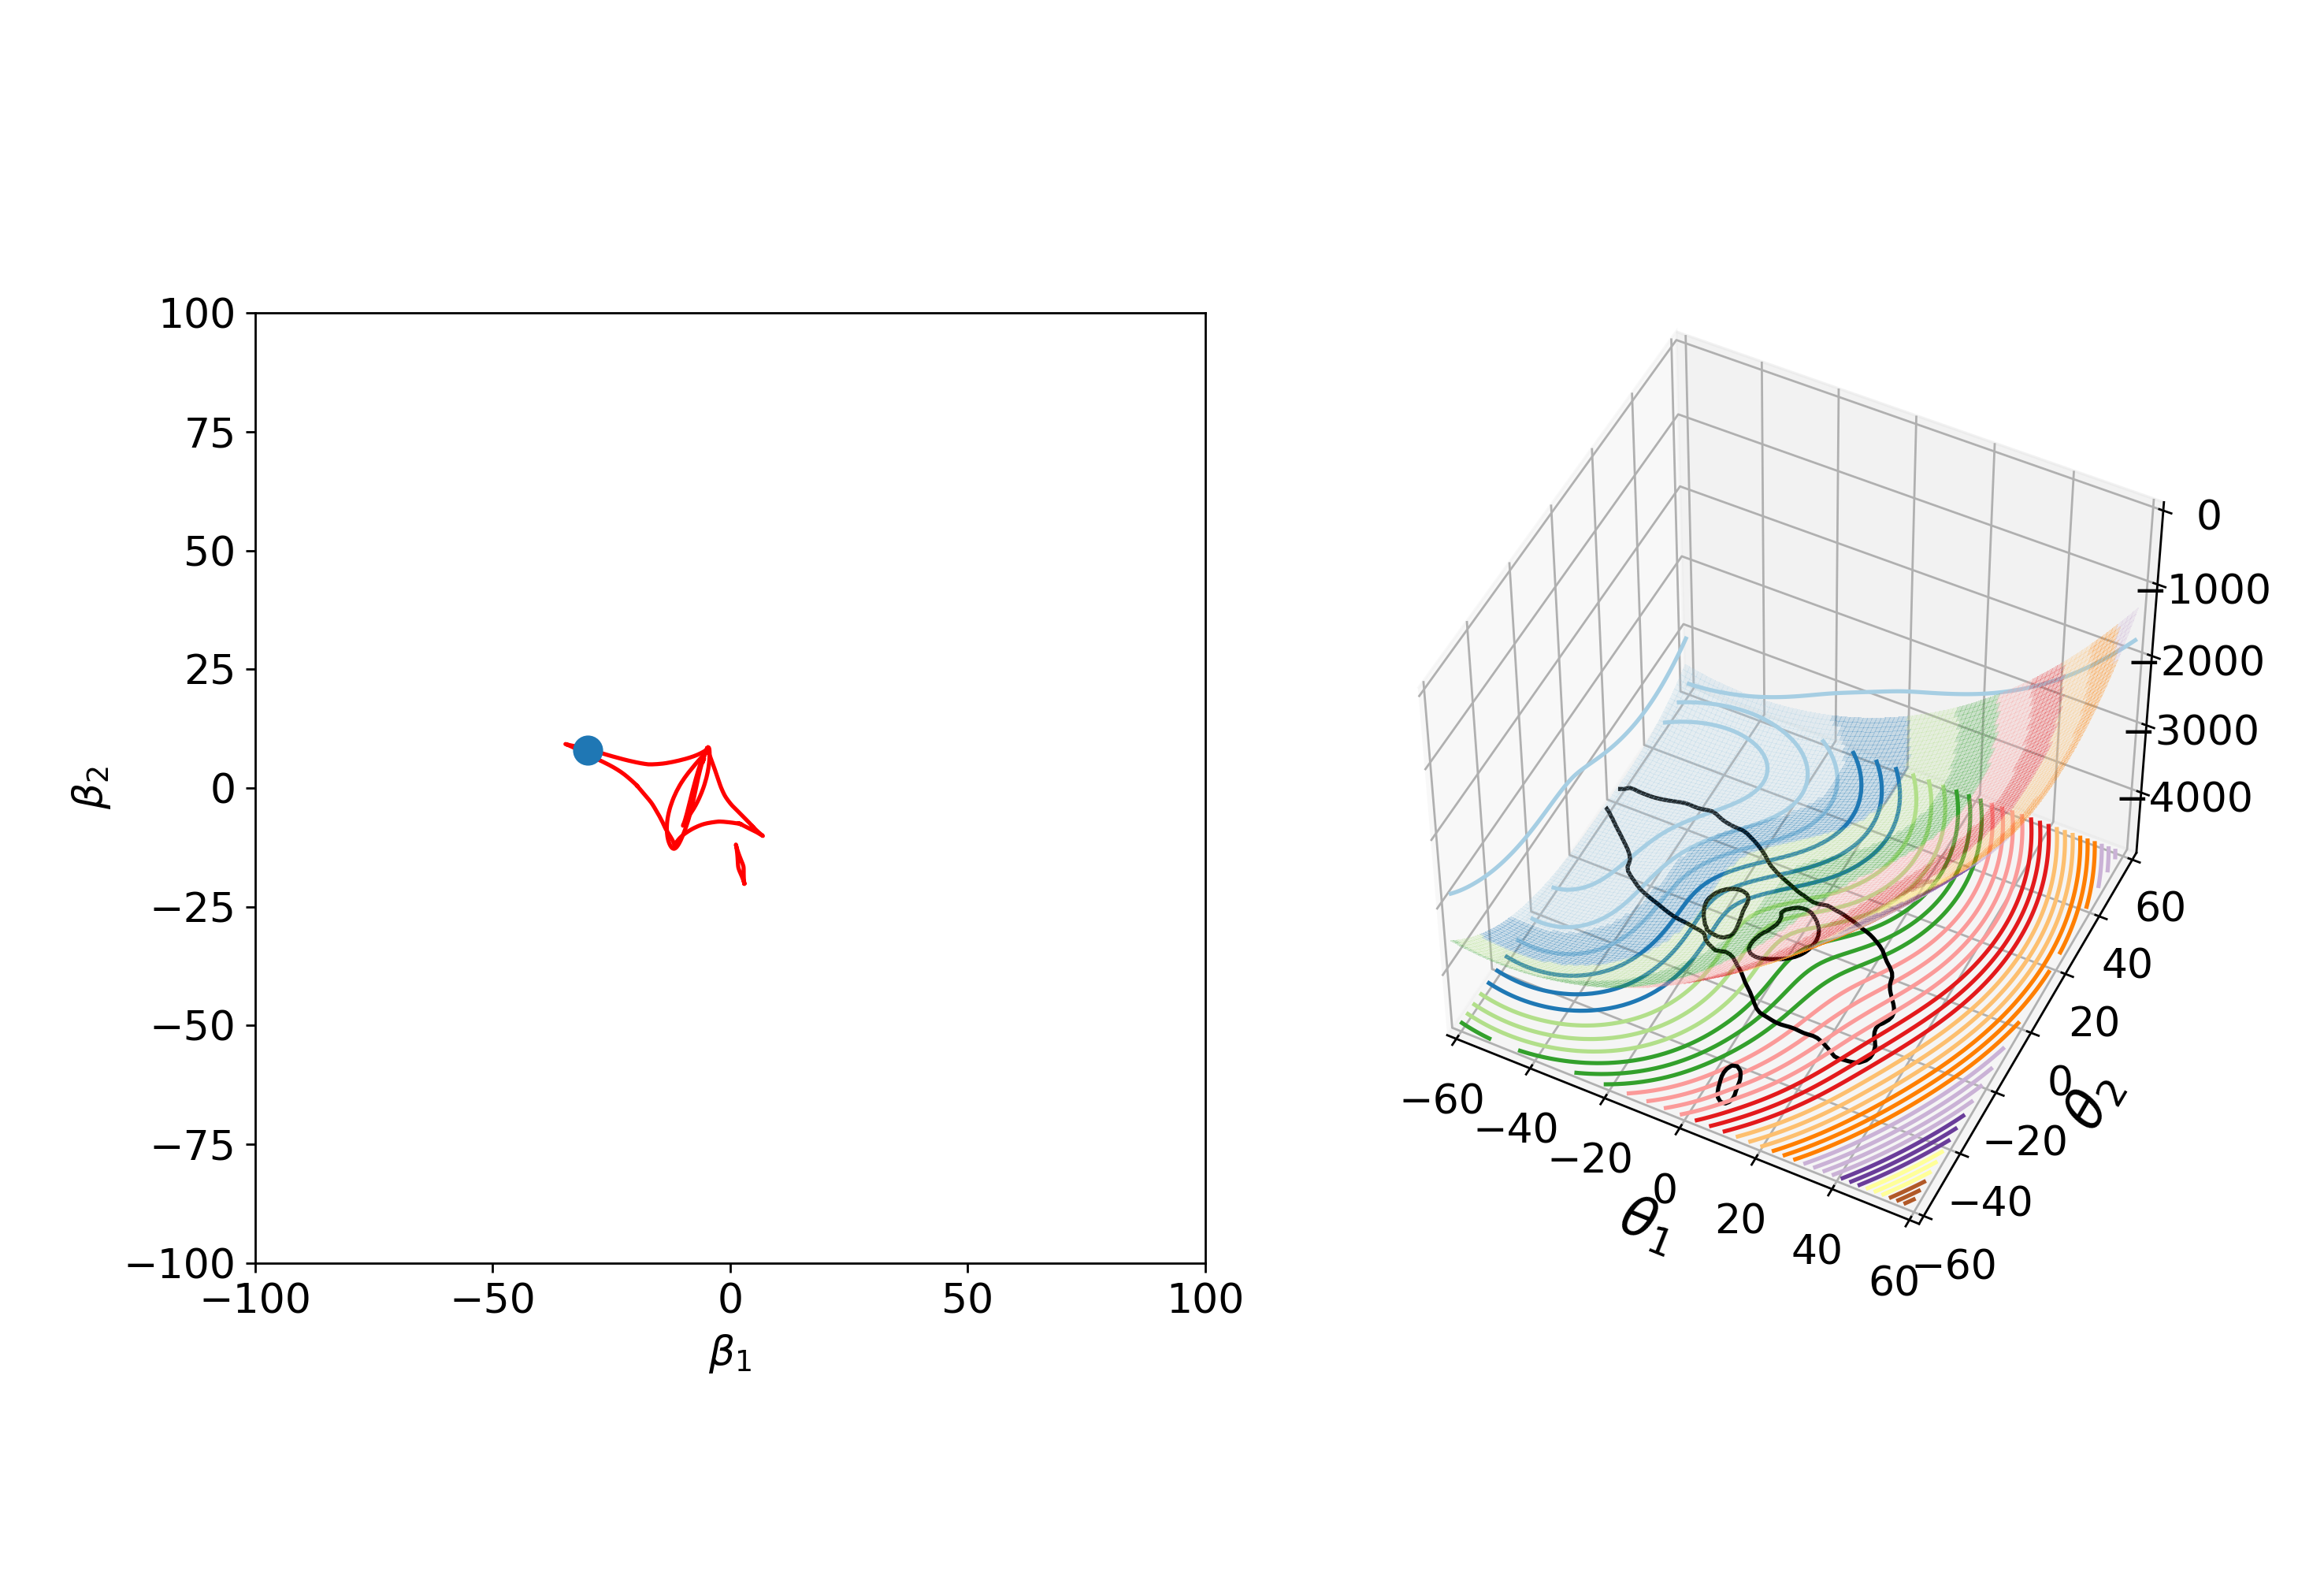

In [8]:
from importlib import reload
reload(plt)
%matplotlib notebook

size=200.0
npix=500
df=deflector('data/kappa_2.fits',True,npix=npix,size=size)

beta=[-9.4,-4.8]
beta=[2.6,-6.8]
beta=[-11.5,-9.5]
beta=[-30,8]

fig = plt.figure(figsize=(11.8,8))
ax=fig.add_subplot(121)
td=df.t_delay_surf(beta=beta)
df.caustics(ax=ax)
ax.plot(beta[0],beta[1],'o',markersize=10)
ax.set_xlim([-100,100])
ax.set_ylim([-100,100])
ax.set_aspect('equal')


ax3d = fig.add_subplot(122, projection='3d')

npix0=100
size0=120.0
df3d=deflector('data/kappa_2.fits',True,npix=npix0,size=size0)
td3d=df3d.t_delay_surf(beta=beta)
df3d.show_surface(td3d,ax=ax3d,minx=-60,miny=-60,offz=-np.max(td3d))
fig.tight_layout()

# Ray-tracing and lensing of a source with Sersic profile

We built a sersic class already. In the following example, we will see how we can reconstruct the distorted images of sources with such a profile. We do not want to consider only first and second order distortions here. We want to perform a full ray-tracing simulation. For this purpose, we add the method ```ray-trace``` to the ```sersic``` class. Provided a lens ``gl`` and some parameters defining the region for ray-tracing (```size```) and the number of rays to trace ```NxN```, the ray-tracing method uses the deflection angles of ```gl``` to trace a grid of light rays passing through a regular grid on the lens plane back to the source plane. Then, the method ```brightness``` associates the value of surface brightness computed at the arrival positions of the light-rays on the source plane to its original position on the lens plane. 

In [4]:
class sersic(object):
    
    def __init__(self,size,N,gl=None,**kwargs):
        
        if ('n' in kwargs):
            self.n=kwargs['n']
        else:
            self.n=4
            
        if ('re' in kwargs):
            self.re=kwargs['re']
        else:
            self.re=5.0
            
        if ('q' in kwargs):
            self.q=kwargs['q']
        else:
            self.q=1.0
            
        if ('pa' in kwargs):
            self.pa=kwargs['pa']
        else:
            self.pa=0.0

        if ('ys1' in kwargs):
            self.ys1=kwargs['ys1']
        else:
            self.ys1=0.0
            
        if ('ys2' in kwargs):
            self.ys2=kwargs['ys2']
        else:
            self.ys2=0.0
            
        self.N=N
        self.size=float(size)
        self.df=gl
        
        # define the pixel coordinates 
        pc=np.linspace(-self.size/2.0,self.size/2.0,self.N)
        self.x1, self.x2 = np.meshgrid(pc,pc)
        if self.df != None:
            y1,y2 = self.ray_trace()
        else:
            y1,y2 = self.x1,self.x2
                    
        self.image=self.brightness(y1,y2)

    def ray_trace(self):
        px=self.df.pixel#size/(self.df.npix-1)
        x1pix=(self.x1+self.df.size/2.0)/px
        x2pix=(self.x2+self.df.size/2.0)/px

        a1 = map_coordinates(self.df.a1,
                             [x2pix,x1pix],order=2)*px
        a2 = map_coordinates(self.df.a2,
                             [x2pix,x1pix],order=2)*px
        
        y1=(self.x1-a1) # y1 coordinates on the source plane
        y2=(self.x2-a2) # y2 coordinates on the source plane
        return(y1,y2)
        
        
    def brightness(self,y1,y2):
        x = np.cos(self.pa)*(y1-self.ys1)+np.sin(self.pa)*(y2-self.ys2)
        y = -np.sin(self.pa)*(y1-self.ys1)+np.cos(self.pa)*(y2-self.ys2)
        r = np.sqrt(((x)/self.q)**2+(y)**2)
        
        # profile
        bn = 1.992*self.n - 0.3271
        brightness = np.exp(-bn*((r/self.re)**(1.0/self.n)-1.0))
        return(brightness)

In the example below, we consider an elliptical sersic source. We build a figure analogous to those shown earlier. We use two panels. On the left, we display the caustics. On the right, we show the critical lines and the contours of equal time delay. Then, we display also the unlensed source on the left and the lensed images on the right. We can see that, as anticipated, the multiple images of the same source form at the at the stationary points of the time-delay surface! By switching the position of the source with respect to the lens, we can reproduce the cases considered above. It is now much clearer that the curvature of the time-delay surface describes the patterns of the magnification. Note, in particular, how images of sources near the caustics are stretched across the critical lines. Another interesting piece of information regards the parity of the images. We can see that regions of opposite parities are separated by the critical lines.

<IPython.core.display.Javascript object>


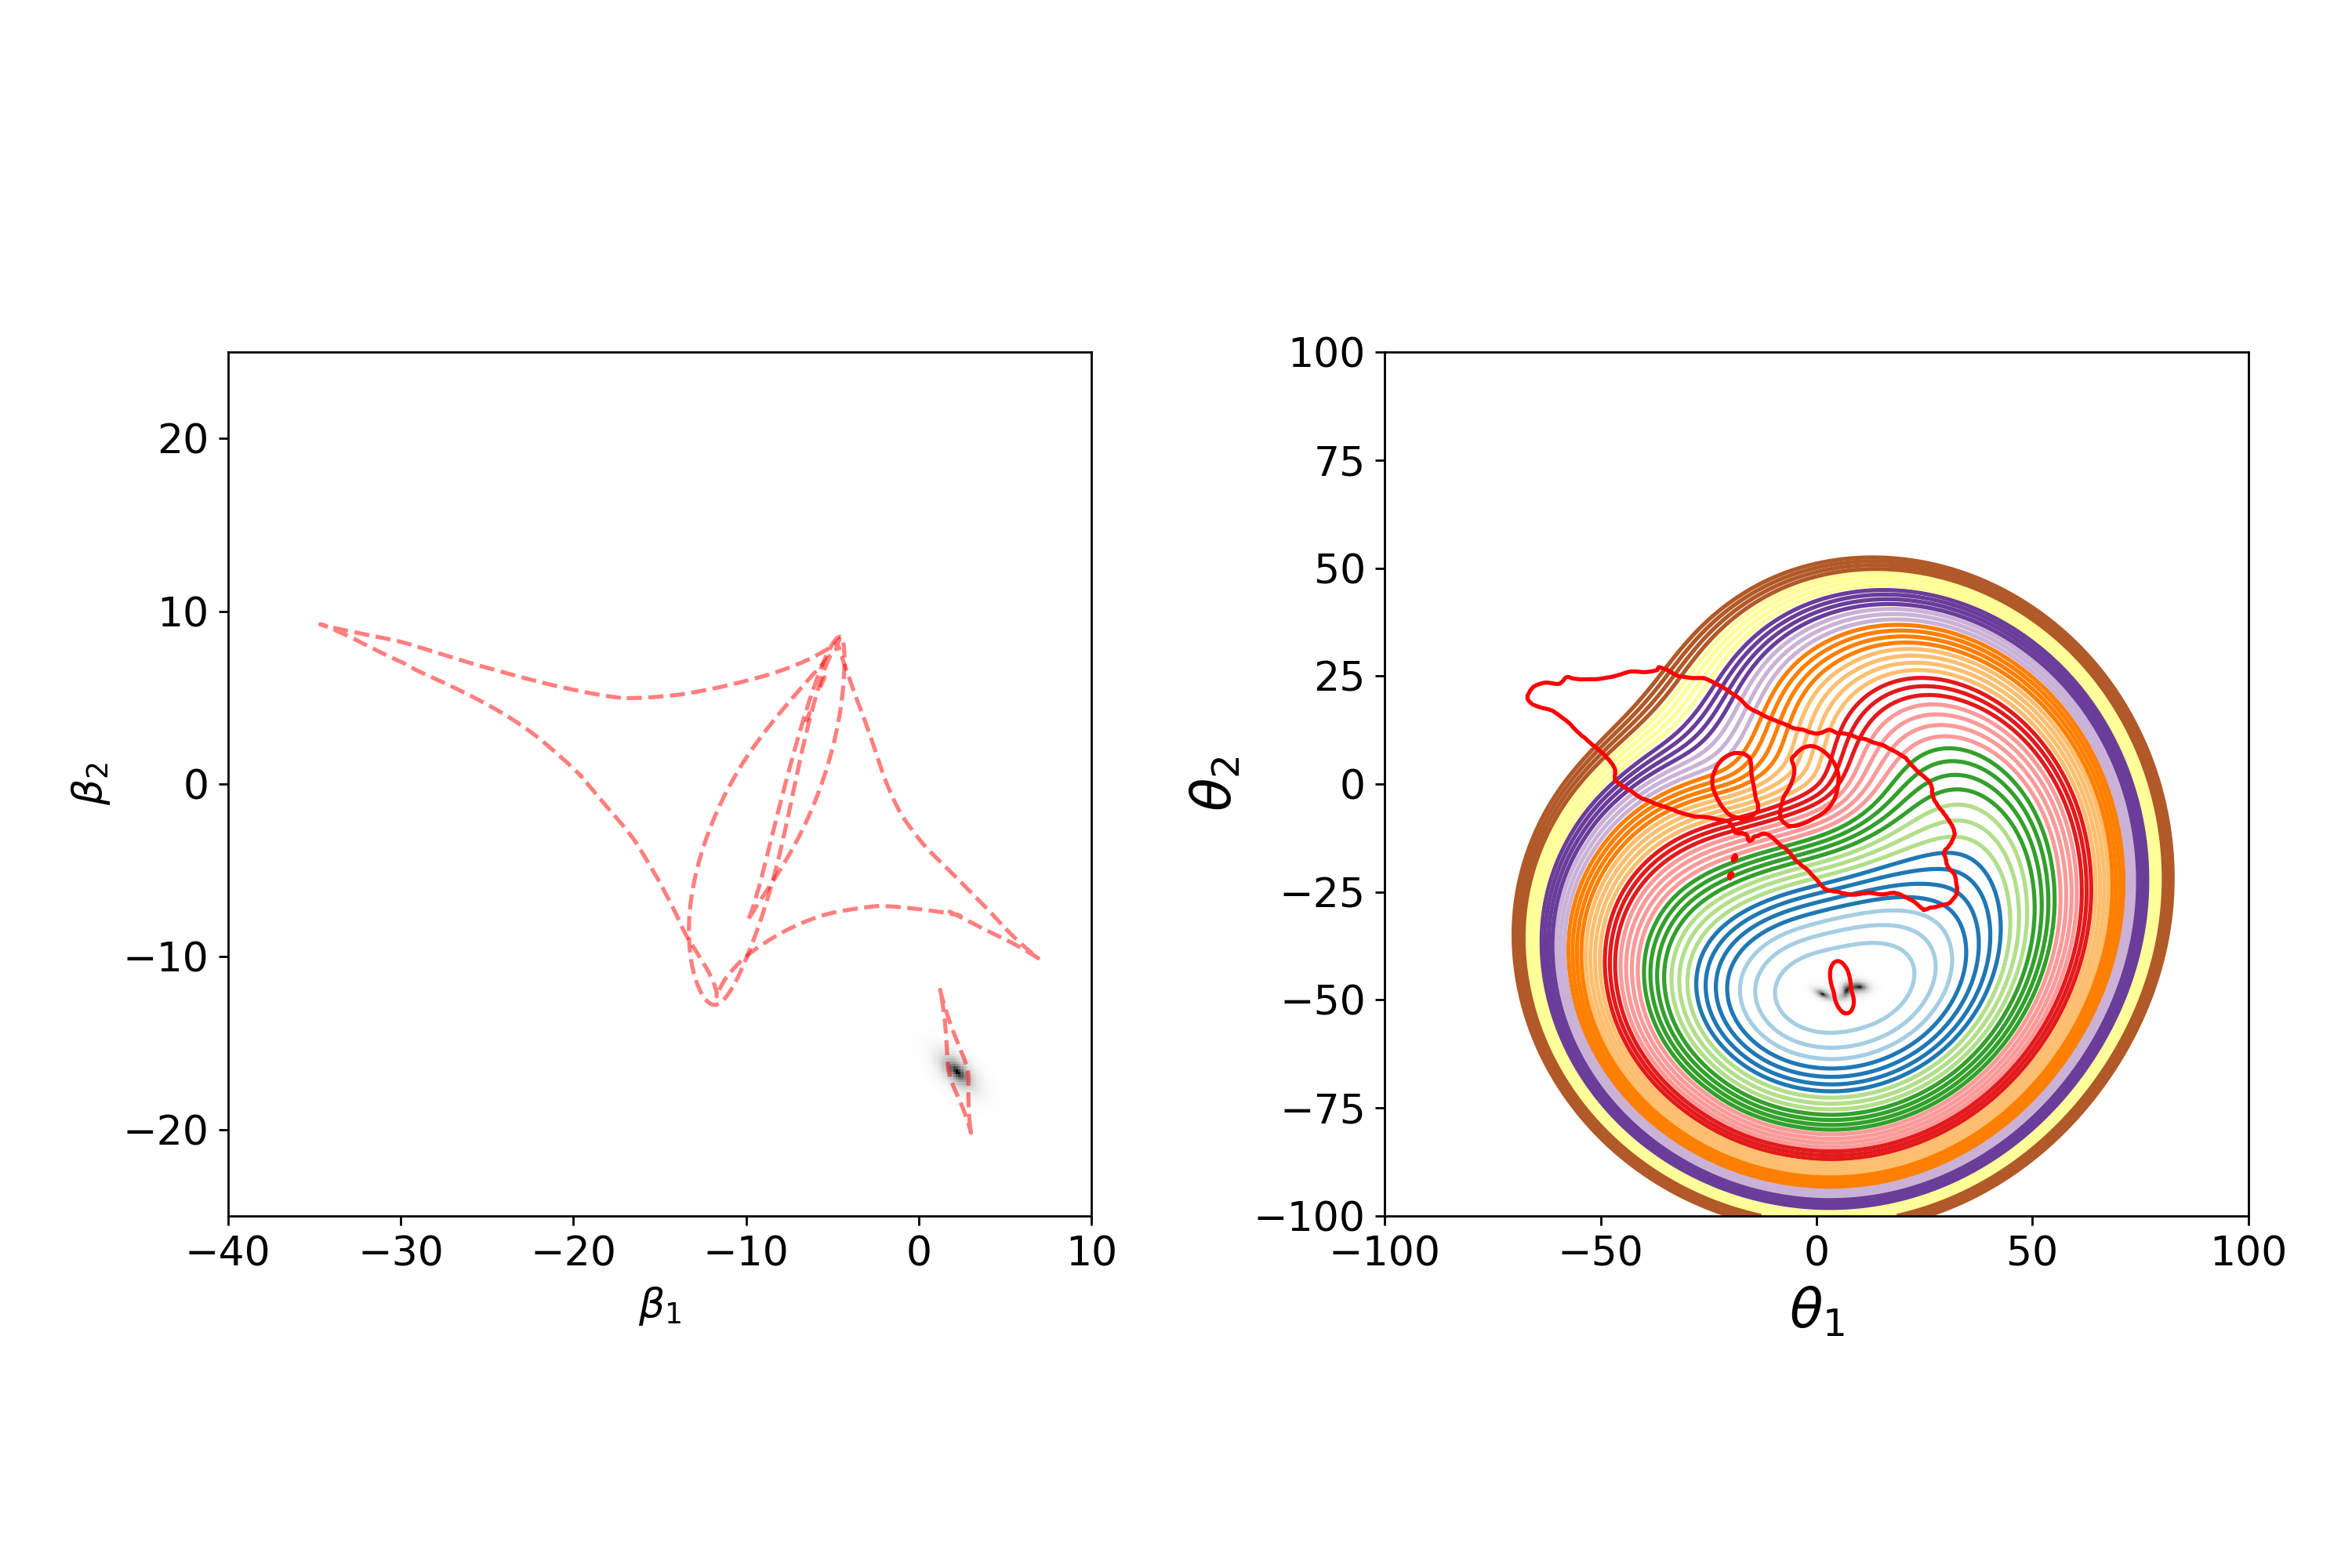

In [14]:


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size

beta=[-9.4,-4.8]
beta=[2.6,-6.8]
beta=[-11.5,-9.5]
beta=[-30,8]

beta=[-10,-1.3]
beta=[-15.7,-4.37]
beta=[2.2,-16.67]

td=df.t_delay_surf(beta=beta)

xmin,xmax=-df.size/2,df.size/2
ymin,ymax=-df.size/2,df.size/2

fig,ax=plt.subplots(1,2,figsize=(12,8))
kwargs={'q': 0.5,'re': 1.0, 'pa': np.pi/4.0, 'n': 1,'ys1': beta[0], 'ys2': beta[1]}


size_stamp=150.0
npix_stamp=1000
se_unlensed=sersic(size_stamp,npix_stamp,**kwargs)
se=sersic(size_stamp,npix_stamp,gl=df,**kwargs)
df.caustics(ax=ax[0],lt='--',alpha=0.5)
df.clines(ax=ax[1])
ax[0].imshow(se_unlensed.image,origin='lower',
             extent=[-se_unlensed.size/2,se_unlensed.size/2,
                     -se_unlensed.size/2,se_unlensed.size/2],
             cmap='gray_r')
ax[1].imshow(se.image,origin='lower',
             extent=[-se.size/2,se.size/2,-se.size/2,se.size/2],
             cmap='gray_r')
df.show_contours(td,ax=ax[1],minx=xmin,miny=ymin,nlevels=45,levmax=1500,fontsize=20)
x0,x1=-40,10
y0,y1=-25,25
ax[0].set_xlim([x0,x1])
ax[0].set_ylim([y0,y1])
fig.tight_layout()